# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!unzip -q "/content/drive/MyDrive/isic-2019.zip" #https://www.kaggle.com/datasets/andrewmvd/isic-2019

Mounted at /content/drive


In [ ]:
import os
#os.system('pip install .')
os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')
os.system('pip install git+https://github.com/hamish-haggerty/cancer-proj.git')
!pip install -qU git+https://github.com/hamish-haggerty/cancer-proj.git #sometimes os doesn't work so use this if imports below fail

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
#TODO: wrap this in an .all
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *

from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module
from statistics import mean,stdev

import fastai
test_eq(fastai.__version__,'2.7.11')

import torch
test_eq(torch.__version__,'1.13.1+cu116')


#Get data paths:

In [ ]:
save_directory = '/content/drive/My Drive/cancer_colab' #directory for saving models etc
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [ ]:
directory = "/content/drive/MyDrive/ISIC_2019_Training_Input/"
data = pd.read_csv("/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
data = data[~data["image"].str.contains("downsampled")]
labels = pd.read_csv("/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv")

data_dict = load_dict_from_gdrive(directory=save_directory,filename='data_dict') 
_fnames = data_dict['_fnames']
#_fnames = get_image_files(directory) 
#_fnames = [name for name in _fnames if 'downsampled' not in name.as_posix()] #otherwise load like this
test_eq(len(_fnames),len(data))

label_func_dict = data_dict['label_func_dict']

def label_func(name):
    return label_func_dict[name]
_labels = [label_func(i) for i in _fnames]

# Build training, tuning, validation test sets:
    - Training is unlabelled
    - Tuning is for supervised fine tuning
    - Validation is a held out (proxy) test set
    - Test set is for getting results

In [ ]:
#tests / sanity checks:
test_eq(process_path(_fnames[0]),'ISIC_0071718.jpg')
test_eq(process_path(_fnames[10]),'ISIC_0071719.jpg')

_fnames_dict = get_fnames(_fnames,_labels,label_func)
fnames_train,fnames_valid,fnames_test = _fnames_dict['fnames_train'],_fnames_dict['fnames_valid'],_fnames_dict['fnames_test'] 
labels_train,labels_valid,labels_test = _fnames_dict['labels_train'],_fnames_dict['labels_valid'],_fnames_dict['labels_test'] 

print(f'Training (tuning) set has: \n{Counter(labels_train)}\n')

print(f'Validation set has: \n{Counter(labels_valid)}\n')

print(f'Test set has: \n{Counter(labels_test)}\n')

#A few tests: Make sure fnames_train and fnames_test the same every time
test_eq(process_path(fnames_train[44]),'ISIC_0071754.jpg')
test_eq(process_path(fnames_test[10]),'ISIC_0000011.jpg')

#Make sure training and valid are disjoint
for path in fnames_valid: assert path not in fnames_train #check that valid set is disjoint from training (tuning) set

#Make sure test and valid+train are disjoint
for path in fnames_test: assert path not in fnames_train+fnames_valid #check that test set is disticnt from training and validation set

Training (tuning) set has: 
Counter({'NV': 500, 'MEL': 500, 'BCC': 500, 'BKL': 467, 'AK': 306, 'SCC': 171, 'VASC': 55, 'DF': 55})

Validation set has: 
Counter({'NV': 458, 'MEL': 309, 'BCC': 274, 'BKL': 110, 'AK': 63, 'SCC': 43, 'VASC': 12, 'DF': 11})

Test set has: 
Counter({'NV': 10601, 'MEL': 3339, 'BCC': 2549, 'BKL': 1663, 'AK': 498, 'SCC': 414, 'VASC': 186, 'DF': 173})



# Setup dataloaders

In [ ]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

size=256
item_tfms = [Resize(size)]

item_tfms_train = [Resize(128)]

dls_tune  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=32,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_valid  = ImageDataLoaders.from_path_func(directory, fnames_valid, label_func,
                                bs=256,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )

#This is for training BT (so viewed as unlabelled)
dls_train  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=128,
                                item_tfms=item_tfms_train,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_test =  ImageDataLoaders.from_path_func(directory, fnames_test, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda'),
                                shuffle=False
                                )

classes_to_int={v:i for i,v in enumerate(dls_tune.vocab)}
int_to_classes = {i: v for i, v in enumerate(dls_tune.vocab)}
vocab=dls_tune.vocab

# Aug pipelines

In [ ]:
aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines'] #Heavy augmentation. Use to train BT
aug_pipelines_tune = aug_dict['aug_pipelines_tune'] #Used for fine tuning
aug_pipelines_test = aug_dict['aug_pipelines_test'] #Test time augmentation (generally same as above)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


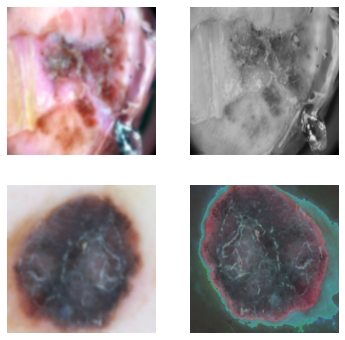

In [ ]:
show_bt_batch(dls_train,n_in=3,n=2,aug=aug_pipelines)

# We need to edit our base functions a bit for this experiment:

In [ ]:
#| export

@torch.no_grad()
def create_model(which_model,device,ps=8192,n_in=3):

    #pretrained=True if 'which_model' in ['bt_pretrain', 'supervised_pretrain'] else False

    if which_model == 'bt_pretrain': model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    
    elif which_model == 'no_pretrain': model = resnet50()

    elif which_model == 'supervised_pretrain': model = resnet50(weights='IMAGENET1K_V2')

    elif which_model == 'vc50_pretrain': model = sequential(torch.hub.load('facebookresearch/vicreg:main', 'resnet50'),nn.Linear(2048,3))

    elif which_model == 'vc200_pretrain': model = sequential(torch.hub.load('facebookresearch/vicreg:main', 'resnet200x2'),nn.Linear(4096,3))

    #ignore the 'pretrained=False' argument here. Just means we use the weights above 
    #(which themselves are either pretrained or not)

    #if which_model !='vc_pretrain':
    encoder = get_resnet_encoder(model)

    model = create_barlow_twins_model(encoder, hidden_size=ps,projection_size=ps,nlayers=3)

    if device == 'cuda':
        model.cuda()
        encoder.cuda()

    return model,encoder

def fine_tune(initial_weights,dls_tune,device,aug_pipelines_tune,encoder=None,epochs=40,tune_model_path=None):
    
    
    if encoder is None: #Generally speaking, this will be None, unless we pretrained an encoder somewhere else and want to pass it in
        _,encoder = create_model(initial_weights,device) #either bt_pretrain, supervised_pretrain etc
    

    print(f'tune_model_path for this run is: {tune_model_path}')

    if initial_weights=='vc200_pretrain':
        numin=4096
        accumulation_steps=2

    else: 
        numin=2048
        accumulation_steps=1
    model = LM(encoder,numout=len(dls_tune.vocab),numin=numin)

    learn = Learner(dls_tune,model,splitter=my_splitter,
                        cbs = [GradientAccumulation(n_acc=accumulation_steps),LinearBt(aug_pipelines=aug_pipelines_tune,
                                        n_in=3,tune_model_path=tune_model_path, #if None then don't save
                                    tune_save_after=epochs)],wd=0.0
                        
                   )
    
    if initial_weights!='no_pretrain': #Means we are in transfer learning setting
        learn.freeze()
        print('Froze body')
        learn.fit(1)
        learn.unfreeze()
        print('Unfroze body')
    
    lrs = learn.lr_find()
    lr_max=lrs.valley
    print(f'Learning rate finder yielded lr_max: {lr_max}')
    learn.fit_one_cycle(epochs,lr_max)

    return model


def get_dls_metrics(dls,model,aug_pipelines_test,int_to_classes): #note that we can't call dls.vocab as it might be smaller on the test set
    "get metrics from model and dataloader"

    ytest,probs,preds,Acc = predict_whole_model(dls,model,aug_pipelines_test,numavg=3)
    metrics = classification_report_wrapper(preds, ytest,int_to_classes, print_report=True)
    
    plot_roc(ytest,probs,int_to_classes)
    auc_dict = Auc_Dict(ytest,probs,int_to_classes)
    print(f'auc_dict is: {auc_dict}')
    plot_pr(ytest,probs,int_to_classes)
    pr_dict = Pr_Dict(ytest,probs,int_to_classes)
    print(f'auc_dict is: {pr_dict}')

    metrics['ytest']=ytest
    metrics['probs']=probs
    metrics['preds']=preds
    metrics['acc']=Acc
    metrics['auc_dict']=auc_dict
    metrics['pr_dict']=pr_dict

    return metrics

def get_xval_metrics(xval,yval,model,aug_pipelines_test,int_to_classes,numavg=3): #note that we can't call dls.vocab as it might be smaller on the test set
    "get metrics from gives batch (xval,yval)"

    probs,preds,Acc = predict_model(xval,yval,model,aug_pipelines_test,numavg=3)
    metrics = classification_report_wrapper(preds, yval,int_to_classes, print_report=True)
    metrics['acc']=Acc

    return metrics

def Mean_Results(results):
    "Get mean classif report and display it"

    lst = list(vocab) + ['accuracy', 'macro avg', 'weighted avg']
    reports=[]
    accs=[]
    for i in results.keys():
        if type(i)!=int:
            continue
        report = {j:results[i][j] for j in results[i].keys() if j in lst}
        reports.append(report)
        accs.append(results[i]['acc'])
    mean_report = Mean_Report(reports,vocab)
    print(format_classification_report(mean_report))
    
    print(f'mean acc is {mean(accs)} with std {stdev(accs)}')

    return mean_report

#fine tune, return the model and path

def main_tune(initial_weights,dls_tune,dls_test,aug_pipelines_tune,aug_pipelines_test,int_to_classes,
              epochs=40,device='cuda',
              encoder=None,tune_model_path=None,dict_path=None,save_directory=None,description=None,
              results=None,runs=range(1)
             ):

    "Fine tune and save  test results for supervised or bt initial weights"

    weights = initial_weights.split('_')[0]

    if description == None:
        description=f'Fine tuned {weights} initial weights for 40 epochs. Recorded results on test sets. Did this {runs} times'

    if dict_path==None:
        dict_path=f'{weights}_results'


    print(f'Description: {description}\n')
    print(f'The general tune model path is: {tune_model_path} (if None mean no saving)')
    print(f'The dict_path is: {dict_path}')
    
    if results==None:
        results={}
    
    for i in runs:

        _tune_model_path = None if tune_model_path is None else tune_model_path + f'_run{i}'

        fine_tuned = fine_tune(initial_weights,dls_tune,device,aug_pipelines_tune,encoder=encoder,epochs=epochs,tune_model_path=_tune_model_path)

        #get the metrics
        metrics = get_dls_metrics(dls_test,fine_tuned,aug_pipelines_test,int_to_classes)
        print(metrics['acc'])
        #put the path in in the metrics and a short description
        metrics['tune_model_path'],metrics['description'] = tune_model_path,description

        results[i] = metrics

    #save
    if tune_model_path!=None:
        print(f'We are saving the dictionary at {dict_path}') #this is a bug. We saved at f'{weights}_results'
        save_dict_to_gdrive(results,save_directory,dict_path)

    return results

# Fine tune VICReg ResNet-50

Description: Fine tuned vc50 initial weights for 40 epochs. Recorded results on test sets. Did this [0, 1, 2] times

The general tune model path is: None (if None mean no saving)
The dict_path is: vc50_results


Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

tune_model_path for this run is: None
Froze body


epoch,train_loss,valid_loss,time
0,1.647423,None,01:08


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze body


Learning rate finder yielded lr_max: 0.0004786300996784121


epoch,train_loss,valid_loss,time
0,1.437952,None,00:17
1,1.402732,None,00:17
2,1.349754,None,00:17
3,1.284236,None,00:17
4,1.191353,None,00:17
5,1.069996,None,00:17
6,0.932339,None,00:17
7,0.763520,None,00:17
8,0.601183,None,00:17
9,0.474018,None,00:17


              precision    recall  f1-score   support

          AK       0.37      0.55      0.44       498
         BCC       0.71      0.73      0.72      2549
         BKL       0.49      0.52      0.50      1663
          DF       0.39      0.25      0.30       173
         MEL       0.54      0.61      0.58      3339
          NV       0.86      0.80      0.83     10601
         SCC       0.42      0.34      0.38       414
        VASC       0.44      0.44      0.44       186

    accuracy                           0.71     19423
   macro avg       0.53      0.53      0.52     19423
weighted avg       0.73      0.71      0.72     19423

auc_dict is: {'AK': 0.932549590700981, 'BCC': 0.9530773466813524, 'BKL': 0.8774192751079402, 'DF': 0.8885597177389084, 'MEL': 0.8451210379559425, 'NV': 0.9064203562664631, 'SCC': 0.8904970770265699, 'VASC': 0.9393624852644517}


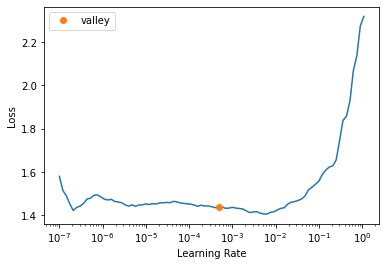

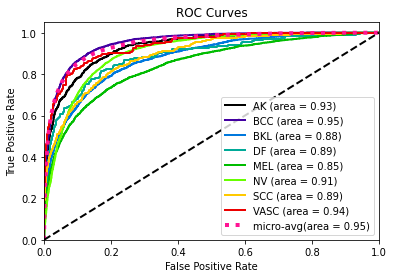

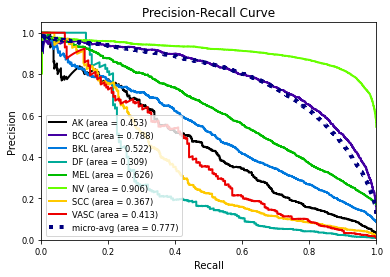

auc_dict is: {'AK': 0.4531363955179846, 'BCC': 0.7882818985895049, 'BKL': 0.5216312948010399, 'DF': 0.30871996043485095, 'MEL': 0.6258503090808161, 'NV': 0.905832684570684, 'SCC': 0.36652525817368686, 'VASC': 0.41313937335857875}
0.7128661870956421


Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


tune_model_path for this run is: None
Froze body


epoch,train_loss,valid_loss,time
0,1.644876,None,00:17


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze body


Learning rate finder yielded lr_max: 0.0004786300996784121


epoch,train_loss,valid_loss,time
0,1.422754,None,00:17
1,1.388028,None,00:17
2,1.345865,None,00:17
3,1.279137,None,00:17
4,1.185958,None,00:17
5,1.068468,None,00:17
6,0.928945,None,00:17
7,0.769726,None,00:17
8,0.601543,None,00:17
9,0.465115,None,00:17


              precision    recall  f1-score   support

          AK       0.37      0.56      0.45       498
         BCC       0.66      0.76      0.70      2549
         BKL       0.50      0.49      0.50      1663
          DF       0.40      0.31      0.35       173
         MEL       0.55      0.61      0.58      3339
          NV       0.86      0.80      0.83     10601
         SCC       0.46      0.33      0.38       414
        VASC       0.50      0.46      0.48       186

    accuracy                           0.71     19423
   macro avg       0.54      0.54      0.53     19423
weighted avg       0.72      0.71      0.72     19423

auc_dict is: {'AK': 0.9266158424981299, 'BCC': 0.9477998213793574, 'BKL': 0.8693022114868928, 'DF': 0.8805828391261916, 'MEL': 0.8434941530758069, 'NV': 0.9039336318027854, 'SCC': 0.8752594435943513, 'VASC': 0.9542324630905609}


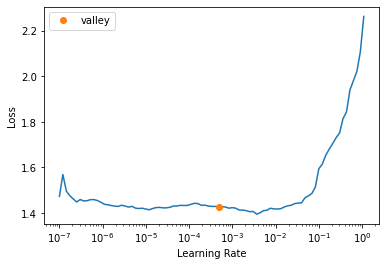

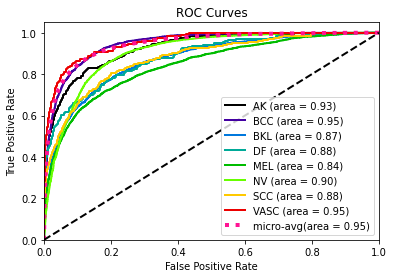

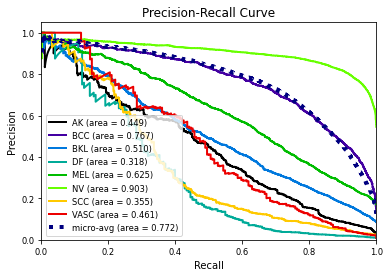

auc_dict is: {'AK': 0.44899629257299484, 'BCC': 0.7672689140073288, 'BKL': 0.5095931261166484, 'DF': 0.31808871362575475, 'MEL': 0.6253931773208141, 'NV': 0.9027429131867761, 'SCC': 0.3548218518561459, 'VASC': 0.46142330151614624}
0.7123513221740723


Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


tune_model_path for this run is: None
Froze body


epoch,train_loss,valid_loss,time
0,1.631613,None,00:17


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze body


Learning rate finder yielded lr_max: 0.00019054606673307717


epoch,train_loss,valid_loss,time
0,1.428760,None,00:17
1,1.409851,None,00:17
2,1.383844,None,00:17
3,1.345527,None,00:17
4,1.295282,None,00:17
5,1.229029,None,00:17
6,1.157599,None,00:17
7,1.068649,None,00:17
8,0.980443,None,00:17
9,0.879854,None,00:17


              precision    recall  f1-score   support

          AK       0.34      0.55      0.42       498
         BCC       0.66      0.72      0.69      2549
         BKL       0.46      0.44      0.45      1663
          DF       0.38      0.23      0.28       173
         MEL       0.48      0.64      0.55      3339
          NV       0.87      0.75      0.81     10601
         SCC       0.39      0.34      0.36       414
        VASC       0.48      0.41      0.44       186

    accuracy                           0.68     19423
   macro avg       0.51      0.51      0.50     19423
weighted avg       0.71      0.68      0.69     19423

auc_dict is: {'AK': 0.9370002069042351, 'BCC': 0.9433624487367731, 'BKL': 0.8395481545887439, 'DF': 0.8702827115081451, 'MEL': 0.8303055689436388, 'NV': 0.8998712410217137, 'SCC': 0.8905479047173943, 'VASC': 0.9471607973210229}


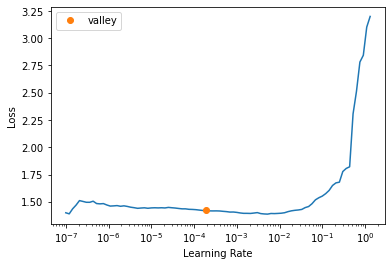

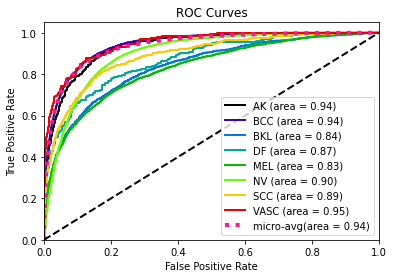

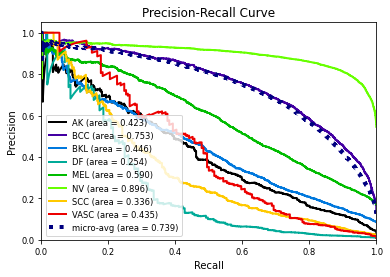

auc_dict is: {'AK': 0.4232782992720786, 'BCC': 0.753341649494263, 'BKL': 0.4458695760135031, 'DF': 0.2538101987990323, 'MEL': 0.5897738043448568, 'NV': 0.8958737164163088, 'SCC': 0.3361833519074458, 'VASC': 0.4353432776449022}
0.6813571453094482


In [ ]:
dls_tune  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )

vc50_results = main_tune(initial_weights='vc50_pretrain',epochs=40,device=device,dls_tune=dls_tune,dls_test=dls_test,
                        aug_pipelines_tune=aug_pipelines_tune,aug_pipelines_test=aug_pipelines_tune,int_to_classes=int_to_classes,
                        tune_model_path=None, dict_path = None,save_directory=save_directory,description=None,
                        results=None,runs=[0,1,2],
                       )

In [ ]:
for k in vc50_results.keys():
    print(vc50_results[k]['acc'])

0.7128661870956421
0.7123513221740723
0.6813571453094482


Exactly in line with BT results on ResNet-50

# Fine tune VICReg ResNet-200 (x2)

Description: Fine tuned vc200 initial weights for 40 epochs. Recorded results on test sets. Did this [1] times

The general tune model path is: None (if None mean no saving)
The dict_path is: vc200_results


Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main
Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet200x2.pth" to /root/.cache/torch/hub/checkpoints/resnet200x2.pth


  0%|          | 0.00/956M [00:00<?, ?B/s]

tune_model_path for this run is: None
Froze body


epoch,train_loss,valid_loss,time
0,1.538129,None,00:36


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Unfroze body


Learning rate finder yielded lr_max: 0.0010000000474974513


epoch,train_loss,valid_loss,time
0,1.264455,None,00:44
1,1.141086,None,00:44
2,0.947497,None,00:44
3,0.673825,None,00:44
4,0.515259,None,00:44
5,0.442263,None,00:44
6,0.409475,None,00:44
7,0.436846,None,00:44
8,0.419052,None,00:44
9,0.344471,None,00:44


              precision    recall  f1-score   support

          AK       0.33      0.64      0.44       498
         BCC       0.75      0.77      0.76      2549
         BKL       0.50      0.49      0.49      1663
          DF       0.59      0.31      0.40       173
         MEL       0.48      0.64      0.55      3339
          NV       0.86      0.76      0.81     10601
         SCC       0.56      0.37      0.44       414
        VASC       0.66      0.67      0.66       186

    accuracy                           0.70     19423
   macro avg       0.59      0.58      0.57     19423
weighted avg       0.73      0.70      0.71     19423

auc_dict is: {'AK': 0.9347638904362496, 'BCC': 0.9607795423519104, 'BKL': 0.8653305853959793, 'DF': 0.8854482396216501, 'MEL': 0.8398877125251163, 'NV': 0.8982429026181663, 'SCC': 0.8857306467849072, 'VASC': 0.9838690113865474}


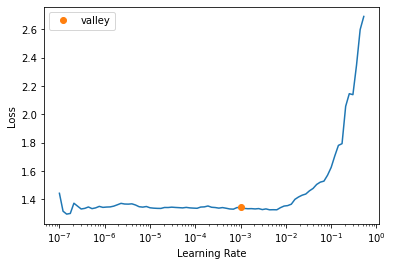

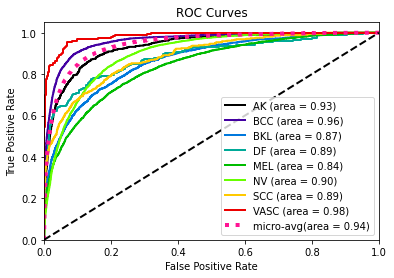

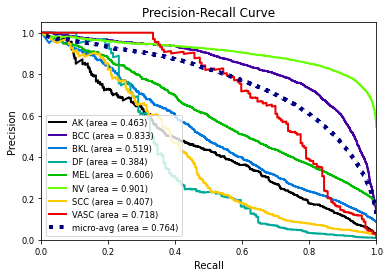

auc_dict is: {'AK': 0.4634532739834007, 'BCC': 0.8332182121001849, 'BKL': 0.5188862374062914, 'DF': 0.383919674959574, 'MEL': 0.6058816814473822, 'NV': 0.9012172839843617, 'SCC': 0.40713014082398397, 'VASC': 0.7184383835898461}
0.698192834854126


In [ ]:
#We still use an effective batch size of 64, (see `fine_tune` above), but need to lower batch size of dls
#for GPU memory requirements
dls_tune  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=32,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )

vc200_results = main_tune(initial_weights='vc200_pretrain',epochs=40,device=device,dls_tune=dls_tune,dls_test=dls_test,
                        aug_pipelines_tune=aug_pipelines_tune,aug_pipelines_test=aug_pipelines_tune,int_to_classes=int_to_classes,
                        tune_model_path=None, dict_path = None,save_directory=save_directory,description=None,
                        results=None,runs=[1],
                       )